# Setup

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import pandas as pd
from pandas import tseries
from datetime import datetime
from datetime import timedelta
import seaborn as sns

import thinkbayes2 as tb

import reporterFun as rf

reporter = rf.GetReporterData()
dayReporter = rf.extractDay(reporter)

# Analyse Activity Patterns

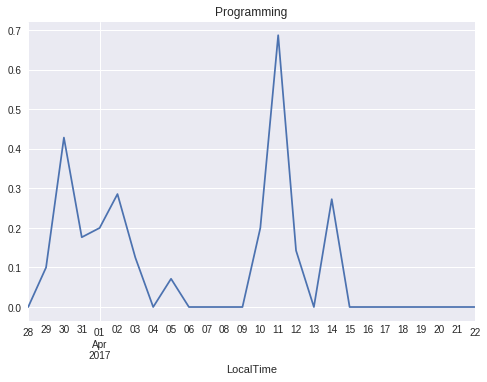

In [2]:
rf.displayToken(dayReporter, 'Activity', 'Programming', display='Date')

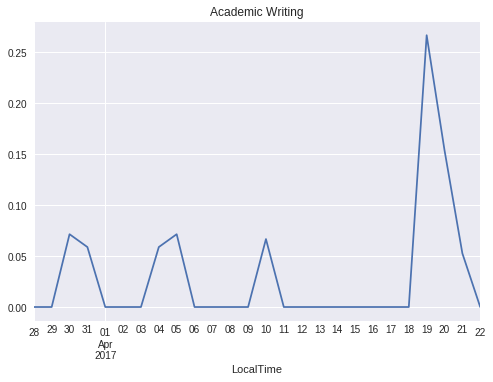

In [3]:
rf.displayToken(dayReporter, 'Activity', 'Academic Writing', display='Date')

## What Activities Make Me Content?

What kinds of work do I find most fulfilling? Simplest options is to ask what activity is linked to content-ness at the same timestep. (We can't reverse this, as all other activities have never made me content and therefore can't be ranked.)

In [4]:
contentObs = rf.extractTokenObs(reporter, tokenType='Mood', token='Content')

# Get boolean matrix of the activities that are taking place in each observation where I'm content.
contentActivity = rf.populateBinaryCols(contentObs['Activity'])

# Over the entire list of observations where I'm content, what proportion of observations include each activity?
# Bear in mind that some activities take place concurrently, so the proportions sum to more than 100%
print(contentActivity.mean().sort_values(ascending=False))

Programming               0.129870
Travelling                0.103896
Chatting                  0.090909
Academic Writing          0.077922
Pleasure Reading          0.077922
Break                     0.064935
Fanfic Reading            0.051948
Watching Anime            0.051948
Browsing                  0.038961
Commuting                 0.038961
Music                     0.025974
Drinking                  0.025974
Computer Gaming           0.025974
Idling                    0.025974
Meditating                0.025974
Eating Out                0.025974
Rowing                    0.025974
Self-Improvement          0.025974
Shopping                  0.025974
Smartphone App            0.025974
Clothes Shopping          0.012987
Eating In                 0.012987
Cooking                   0.012987
Academic Reading          0.012987
Watching the Fire         0.012987
Making Tea                0.012987
Fiction Writing           0.012987
Game Reviews              0.012987
Getting Dressed     

In [5]:
# Proportions without splitting
print contentObs['Activity'].value_counts(ascending=False, normalize=True)

Programming                           0.116883
Academic Writing                      0.077922
Travelling                            0.064935
Watching Anime                        0.051948
Pleasure Reading                      0.038961
Commuting                             0.038961
Fanfic Reading                        0.038961
Chatting                              0.038961
Computer Gaming                       0.025974
Rowing                                0.025974
Drinking                              0.025974
Self-Improvement                      0.025974
Browsing                              0.025974
Idling                                0.025974
Eating Out,Pleasure Reading           0.012987
Academic Reading                      0.012987
Break,Meditating                      0.012987
Watching Theatre                      0.012987
Making Tea                            0.012987
Game Reviews,Break                    0.012987
Planning,Chatting                     0.012987
Clothes Shopp

In [6]:
# Over the entire list of observations where I'm content, how many times does each activity appear?
print(contentActivity.sum().sort_values(ascending=False))

Programming               10
Travelling                 8
Chatting                   7
Academic Writing           6
Pleasure Reading           6
Break                      5
Fanfic Reading             4
Watching Anime             4
Browsing                   3
Commuting                  3
Music                      2
Drinking                   2
Computer Gaming            2
Idling                     2
Meditating                 2
Eating Out                 2
Rowing                     2
Self-Improvement           2
Shopping                   2
Smartphone App             2
Clothes Shopping           1
Eating In                  1
Cooking                    1
Academic Reading           1
Watching the Fire          1
Making Tea                 1
Fiction Writing            1
Game Reviews               1
Getting Dressed            1
Watching Theatre           1
Packing Up                 1
Planning                   1
Presenting                 1
Studying Statistics        1
Transcribing  

In [7]:
# Counts without splitting
print contentObs['Activity'].value_counts(ascending=False)

Programming                           9
Academic Writing                      6
Travelling                            5
Watching Anime                        4
Pleasure Reading                      3
Commuting                             3
Fanfic Reading                        3
Chatting                              3
Computer Gaming                       2
Rowing                                2
Drinking                              2
Self-Improvement                      2
Browsing                              2
Idling                                2
Eating Out,Pleasure Reading           1
Academic Reading                      1
Break,Meditating                      1
Watching Theatre                      1
Making Tea                            1
Game Reviews,Break                    1
Planning,Chatting                     1
Clothes Shopping                      1
Watching Fantasy Anime                1
Packing Up                            1
Smartphone App                        1


Extracting the work-related ones, the results are: Programming, Academic Writing, Academic reading, Presenting, and Academic Editing, in that order.

Worth noting that no single activity accounts for more than about 10% of contentness.

# What activities will make me content?
Above we have answered 'what activities am I most likely to be doing when I am content?'

What we really want to know is, will doing these activities make me content?

In other words I have a set of P(B|A), the probability that I will be doing activity B given that I am content (A). What I am after is P(A|B), the probability that I will be content if I am doing activity B.

## What activities will make me content? Bayes
I suppose this could be seen as a Bayesian question.

For B = a given activity (programming), p(A|B) = (p(B|A) * p(A))/p(B).

So my prior is P(A), or the probability that I am content regardless of what I'm doing. This is known:

In [8]:
contentObs = rf.extractTokenObs(dayReporter, tokenType='Mood', token='Content')
print contentObs.shape
print dayReporter.shape
#print reporter.shape[0] - contentObs.shape[0]
prior = float(contentObs.shape[0])/dayReporter.shape[0]
print prior

(77, 19)
(328, 19)
0.234756097561


My likelihood is p(B|A), or the probability that I will be programming if I am content. This is also known:

In [9]:
contentObs = rf.extractTokenObs(dayReporter, tokenType='Mood', token='Content')
contentActivity = rf.populateBinaryCols(contentObs['Activity'])
likelihood = contentActivity['Programming'].mean()
print likelihood

0.12987012987


My normalising constant is p(B), the probability that I am programming. This is *also* known:

In [10]:
programmingObs = rf.extractTokenObs(dayReporter, tokenType='Activity', token='Programming')
print programmingObs.shape
print dayReporter.shape
normConstant = float(programmingObs.shape[0])/dayReporter.shape[0]
print normConstant

(39, 19)
(328, 19)
0.118902439024


So the probability that I will be content if I am programming is:

In [11]:
posterior = (prior*likelihood)/normConstant
print posterior

0.25641025641


Yay! Awkwardly but usefully, I think this is also known, so we can test it:

In [12]:
programmingMood = rf.populateBinaryCols(programmingObs['Mood'])
contentProb = programmingMood['Content'].mean()
print contentProb

0.25641025641


**Victory!**

## What activities will make me content? Diachronic Bayes

Above I calculated the probability of being content while I was programming, notated as p(Content|Programming) or p(A|B).

The diachronic interpretation says that what I was doing was actually updating p(H|D) where H is a hypothesis and D is data.

Under the simplest possible usage, p(H) is therefore p(A), the probability that I am content, and so H is the hypothesis: 'I am content'. The probability that I am content is my prior.

p(D|H) is the probability of the data under the hypothesis. This is equivalent to p(B|A) i.e. the probability that I am programming if I am content. My data is therefore 'I am programming'. My likelihood is p(D|H), the probability that 'I am programming' given that 'I am content.'

Finally my normalising constant is the probability of my data, i.e. the probability that 'I am programming.'

H = A: 'I am content.'
D = B: 'I am programming.'

*The effect of all this is a version of the cookie problem. I have a known initial probability of being content or not, and I know (from the CSV data) how likely I am to be programming when I am content. Bayes' theorem will therefore tell me how likely I am to be content, given how much I am programming. If I tell it that I am programming enough, it will tell me that I am content with 100% probability.*

We can code this using a ThinkBayes2 Suite object:

In [13]:
class Content(tb.Suite):
    
    def __init__(self, reporter, hypo):
        tb.Suite.__init__(self, hypo)
        self.reporter = reporter
    
    # probability of observing data under hypothesis, where:
    # data is 'I am programming' or 'I am not programming'
    # hypothesis is 'I am content' or 'I am not content'
    def Likelihood(self, data, hypo):
        content = hypo # can be true or not true
        programming = data # can be true or not true
        #print('Content = ' + str(content))
        #print('Programming = ' + str(programming))
        
        # get all obs with content == true
        #contentObs = rf.extractTokenObs(reporter, tokenType='Mood', token='Content')
        
        # get the probability that 'I am programming' in obs where 'I am content.'
        # i.e. p(D|H) if D = 'I am programming' and H = 'I am content'
        #contentActivity = rf.populateBinaryCols(contentObs['Activity'])
        #likelihood = contentActivity['Programming'].mean()
        #print likelihood
        
        ## GENERAL CASE
        # get obs where content == hypo
        contentObs = rf.extractTokenObs(dayReporter, tokenType='Mood', token='Content')
        if content == 'amContent':
            # obs where 'I am content'
            obs = contentObs
        else:
            # obs where 'I am not content'
            obs = dayReporter.drop(contentObs.index) 
        #print obs.shape
            
        # get the probability that programming == data when content == hypo
        activity = rf.populateBinaryCols(obs['Activity'])
        if programming == True:
            # probability that 'I am programming' with the above obs
            likelihood = activity['Programming'].mean()
        else:
            # probability that 'I am not programming' with the above obs
            likelihood = 1 - activity['Programming'].mean()
        #print likelihood
        return likelihood

We call this object with two hypotheses, 'C' for 'I am content' and 'notContent' for 'I am not content'. Each one is assigned a prior probability calculated from the existing data.

In [14]:
#contentObs = rf.extractTokenObs(dayReporter, tokenType='Mood', token='Content')
#priorAmC = float(contentObs.shape[0])/dayReporter.shape[0]
#priorNotC = 1 - priorAmC
#print priorAmC
#print priorNotC

#contentSuite = Content(reporter=dayReporter, hypo=dict(amContent=priorAmC, notContent=priorNotC))
contentSuite= Content(reporter=dayReporter, hypo=(('amContent', 'notContent')))
contentSuite.Print()

amContent 0.5
notContent 0.5


We then update the object with new data. We wish to calculate p(H|D), which was formerly p(A|B) i.e. the probability that 'I am content' given that 'I am programming.' When the object is updated, it updates both hypotheses.

In [15]:
for i in range(0, 100):
    contentSuite.Update(True)
    contentSuite.Normalize()
contentSuite.Print()

amContent 0.999991653651
notContent 8.34634887714e-06


## What activities will make me content? Diachronic, second try.
Input: a tuple of (am I happy? , what am I doing?)

Set of Bayesian analysers: programming, eating etc. Depending on what I am doing, data is funelled to the appropriate one.

Data: am I happy, or am I not happy? I.e. 'amContent' or 'notContent'

Hypothesis: doing this will make me content with x probability.

Prior: don't know whether something will make me happy unless I try, so uniform amContent / notContent.

Likelihood: prob. of being amContent / notContent with hypothesised probability.

In [16]:
programmingObs = rf.extractTokenObs(dayReporter, tokenType='Activity', token='Programming')
programmingMood = rf.populateBinaryCols(programmingObs['Mood'])
programmingContent = programmingMood['Content'].sum()
programmingNotContent = programmingObs.shape[0]-programmingContent
print('Content: ' + str(programmingContent))
print('Not Content: ' + str(programmingNotContent))

Content: 10
Not Content: 29


0.268292682927


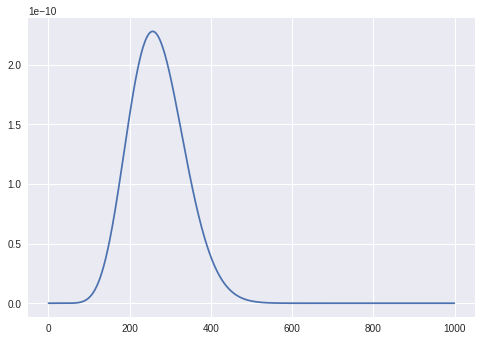

In [17]:
programBeta = tb.Beta(alpha=1, beta=1)
programBeta.Update((programmingContent,programmingNotContent))
print programBeta.Mean()
samples = np.zeros(len(range(0,1000)))
for i in (range(0,1000)):
    samples[i] = programBeta.EvalPdf(i/1000.0)
plt.plot(samples)

Which is about what we got from the frequentist analogy. But I only have so much data. If I start with a prior heavily skewed towards optimism, I get a more optimistic result.

0.392156862745


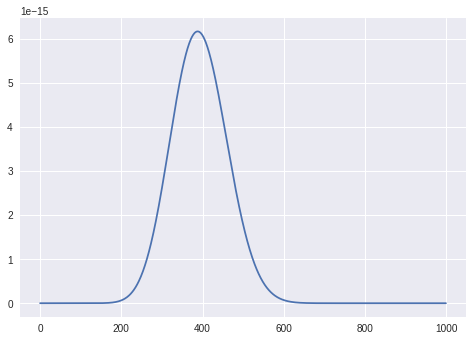

In [18]:
programBeta = tb.Beta(alpha=10, beta=2)
programBeta.Update((programmingContent,programmingNotContent))
print programBeta.Mean()
samples = np.zeros(len(range(0,1000)))
for i in (range(0,1000)):
    samples[i] = programBeta.EvalPdf(i/1000.0)
plt.plot(samples)

## What Activities Will Make Me Content? Diachronic, General

<thinkbayes2.Beta instance at 0x7f7965a94fc8>

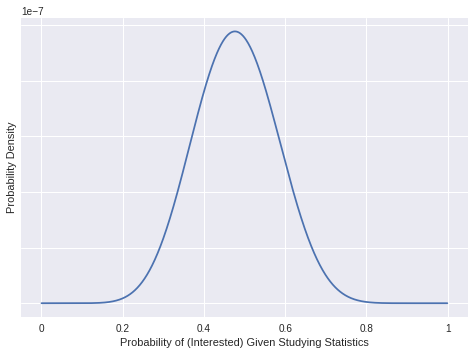

In [2]:
rf.targetBayes(dayReporter, 'Activity', 'Studying Statistics', 'Mood', 'Interested', display=True)

In [1]:
# For unique activity
uniqueActivities = rf.getUnique(dayReporter['Activity'])
bayesList = {}
for activity in uniqueActivities:
    # Create a bayesian operator, update it, and add it to the list.
    try:
        bayesList[activity] = rf.contentBayes(dayReporter, 'Activity', activity)
    except KeyError:
        continue

NameError: name 'rf' is not defined

# Mood vs. Activity

In [ ]:
# Get amount of mood
dataf = rf.tokenDailyResampled(dayReporter, 'Mood', 'Interested', sampleType = 'mean')


wake = wakeReporter.copy()
wake.index = wake['LocalTime']
wake.index = wake.index.date + pd.DateOffset(hours = 5)
wake.loc[:, 'SleepDuration'] = wake['SleepDuration'].dt.seconds/60.0/60.0

# Merge, and Remove Days Which Are Not Consecutive 
wake = wake.merge(dataf, how='inner', right_index=True, left_index=True)
wake = wake[getIdxTimeDifference(wake) == timedelta(days=1)]
sns.swarmplot(x=wake['Slept'], y=wake['Tired'])

sns.plt.figure()
sns.plt.scatter(x=wake['SleepDuration'], y=wake['Tired'])